In [8]:
import pandas as pd
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt

import requests
import json
import hvplot.pandas
from holoviews.operation.datashader import rasterize

# Optionally, you can import the module below if you'd rather use the CDC's API to access data.
# However, you can't get an API Token without working for them, so I do not recommend doing things this way given their throttling limits.
# from sodapy import Socrata

In [9]:
# Get data
test_df = pd.read_csv("shorterdf.csv")
# All money columns here in thousands of dollars
# Also dropped 3 rows because some ZIPs didn't have coordinates, apparently
test_df = test_df.drop(["Unnamed: 0", "index"], axis=1).dropna(axis="index", how="any").rename(columns={"N2":"Total Individuals", "A02650":"AGI"})
test_df

,STATE,ZIPCODE,Total Individuals,AGI,Total Income per Individual,lng,lat
0,MS,38738,140.0,5.770000e+02,4.121429,-90.53653,33.93049
1,MO,64147,280.0,1.591000e+03,5.682143,-94.54688,38.85387
2,SD,57794,390.0,3.206000e+03,8.220513,-102.40695,43.12071
3,TN,37140,390.0,3.239000e+03,8.305128,-87.65245,35.86345
4,MT,59444,270.0,2.321000e+03,8.596297,-111.34881,48.65227
...,...,...,...,...,...,...,...
27637,CA,94301,14750.0,1.527798e+07,1035.795390,-122.14992,37.44424
27638,CA,94027,5820.0,6.971688e+06,1197.884536,-122.20313,37.45399
27639,FL,33480,9050.0,1.466156e+07,1620.061768,-80.04075,26.69796
27640,CA,94104,1510.0,2.990505e+06,1980.466887,-122.40211,37.79144


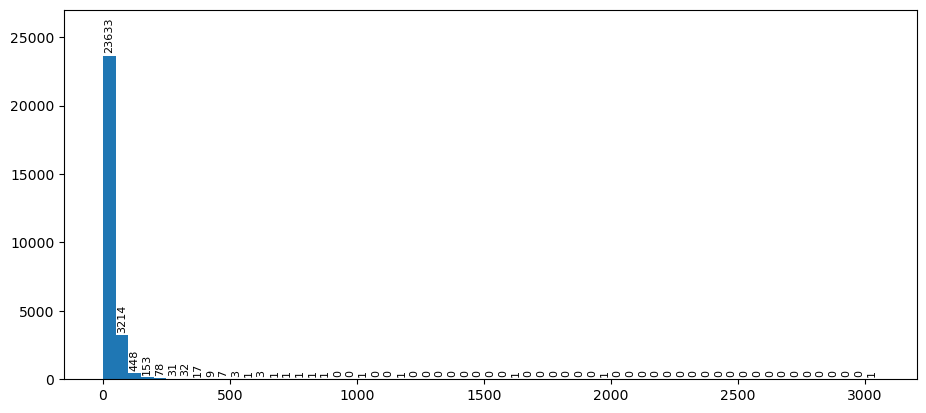

In [10]:
dbins = [i*50.0 for i in range(62)]
plt.figure(figsize=(11,4.8)) 
counts, bins, bars = plt.hist(test_df["Total Income per Individual"], bins=dbins)
plt.bar_label(bars, fontsize=8, rotation="vertical", padding=2)
plt.ylim(0,27000)

plt.show()
# If you're wondering why the chart is so wide, it's because wealth disparity is a bitch and the Income/Capita in Miami Beach is $3 million.

In [11]:
# Map starts out pretty far because we're also including Hawaii and Alaska
# Non-datashaded map works, but it's super laggy with 27k points, so we'll stick with this for big visualizations
money_plot = test_df.hvplot.points(
    "lng",
    "lat",
    geo = True,
    tiles = "CartoLight",
    frame_width = 800,
    frame_height = 400,
    scale = .7,
    color = "Total Income per Individual",
    cmap = "hot_r",
    colorbar = True,
    datashade=True,
    dynspread=True,
    xlabel="Longitude",
    ylabel="Latitude",
    title= "ZIPCODES by MONEY"
)

money_plot

:DynamicMap   []
   :Overlay
      .Tiles.I :Tiles   [x,y]
      .RGB.I   :RGB   [lng,lat]   (R,G,B,A)

In [12]:
# State View
teststate_df = test_df.loc[test_df["STATE"]=="NY"]

money_plot = teststate_df.hvplot.points(
    "lng",
    "lat",
    geo = True,
    tiles = "CartoLight",
    frame_width = 800,
    frame_height = 400,
    scale = .7,
    color = "Total Income per Individual",
    cmap = "hot_r",
    colorbar = True,
    xlabel="Longitude",
    ylabel="Latitude",
    title= "ZIPCODES by MONEY"
)

money_plot

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lng,lat]   (Total Income per Individual)

In [13]:
# TODO: make correlation matrix between AGI/capita and the other columns from the medical data set
# Columns I'm interested in: any columns with a correlation coefficient of >0.6 
med_df = pd.read_csv("PLACES__ZCTA_Data__GIS_Friendly_Format___2022_release.csv")
med_df

# TotalPopulation and Geolocation columns match up pretty well with the tax information dataset, so these columns are safe to ignore

,ZCTA5,TotalPopulation,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,BINGE_CrudePrev,BINGE_Crude95CI,BPHIGH_CrudePrev,BPHIGH_Crude95CI,...,OBESITY_Crude95CI,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation
0,8065,7398,11.8,"(10.6, 13.0)",23.6,"(22.8, 24.3)",17.0,"(16.8, 17.2)",NaN,NaN,...,"(31.5, 33.0)",9.2,"( 8.7, 9.7)",36.9,"(36.0, 37.7)",2.8,"( 2.7, 3.0)",12.4,"(10.0, 15.2)",POINT (-75.035071 40.00536195)
1,28443,17512,13.7,"(12.4, 15.1)",25.2,"(24.5, 25.9)",16.3,"(16.1, 16.5)",33.1,"(32.3, 33.8)",...,"(27.3, 28.8)",9.2,"( 8.7, 9.7)",32.0,"(31.2, 32.8)",2.8,"( 2.7, 3.0)",10.3,"( 8.6, 12.6)",POINT (-77.67400103 34.40735763)
2,3103,36476,16.1,"(15.2, 17.1)",23.4,"(22.9, 23.8)",18.0,"(17.8, 18.2)",29.4,"(29.0, 29.8)",...,"(32.4, 33.4)",11.3,"(10.8, 11.7)",36.2,"(35.7, 36.7)",2.8,"( 2.6, 2.9)",17.0,"(14.5, 19.7)",POINT (-71.44426868 42.95332718)
3,4042,4281,12.0,"( 9.6, 14.7)",25.6,"(24.2, 26.9)",16.6,"(16.0, 17.2)",29.7,"(28.3, 31.1)",...,"(29.3, 32.5)",8.5,"( 7.5, 9.5)",33.1,"(31.4, 34.7)",2.4,"( 2.2, 2.7)",13.0,"( 8.4, 18.3)",POINT (-70.62451707 43.62953242)
4,1109,30250,14.1,"(13.2, 15.1)",24.6,"(24.3, 24.9)",14.8,"(14.5, 14.9)",33.9,"(33.6, 34.2)",...,"(37.7, 38.6)",12.4,"(12.0, 12.8)",42.2,"(41.6, 42.7)",4.0,"( 3.8, 4.1)",25.6,"(23.3, 28.0)",POINT (-72.54882748 42.11839795)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32404,90249,26669,15.7,"(14.7, 16.8)",17.9,"(17.5, 18.3)",15.6,"(15.5, 15.7)",29.8,"(29.4, 30.2)",...,"(29.4, 30.4)",9.8,"( 9.4, 10.2)",35.6,"(35.0, 36.1)",3.0,"( 2.9, 3.2)",11.2,"( 9.2, 13.8)",POINT (-118.3170528 33.90148653)
32405,92551,30815,21.0,"(19.7, 22.3)",17.1,"(16.9, 17.4)",19.0,"(18.8, 19.2)",27.4,"(27.1, 27.7)",...,"(36.6, 37.4)",11.0,"(10.6, 11.4)",37.6,"(37.1, 38.0)",2.5,"( 2.4, 2.6)",14.6,"(13.4, 15.9)",POINT (-117.2261219 33.88144718)
32406,98226,41235,10.3,"( 9.7, 11.0)",24.8,"(24.3, 25.3)",19.0,"(18.8, 19.2)",29.8,"(29.3, 30.2)",...,"(27.4, 28.2)",10.4,"(10.1, 10.7)",28.4,"(28.0, 28.8)",3.0,"( 2.8, 3.1)",11.5,"( 9.8, 13.4)",POINT (-122.4247832 48.80190392)
32407,87553,1209,19.8,"(16.5, 23.5)",25.2,"(24.2, 26.3)",11.9,"(11.5, 12.1)",35.0,"(33.8, 36.2)",...,"(27.8, 29.6)",13.9,"(13.2, 14.7)",32.4,"(31.6, 33.3)",3.9,"( 3.5, 4.3)",15.3,"(12.6, 18.5)",POINT (-105.706967 36.20595411)


In [14]:
med_df.loc[med_df["ZCTA5"]==33109]

,ZCTA5,TotalPopulation,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,BINGE_CrudePrev,BINGE_Crude95CI,BPHIGH_CrudePrev,BPHIGH_Crude95CI,...,OBESITY_Crude95CI,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation
16099,33109,594,16.7,"(13.6, 20.1)",30.8,"(28.6, 33.0)",11.0,"(10.7, 11.2)",40.9,"(38.8, 42.9)",...,"(24.0, 26.4)",12.5,"(10.9, 14.3)",30.8,"(29.3, 32.1)",4.3,"( 3.5, 5.2)",11.5,"( 6.6, 18.1)",POINT (-80.14132101 25.75993225)


In [69]:
# We'll ignore any of the CI columns and keep the ZCTA5 column, so there should be 31 columns left
prev_df = med_df.filter(like="Prev")
prev_df.insert(0, "ZIPCODE", med_df.loc[:, "ZCTA5"])
a_df = prev_df.dropna(axis="index", how="any")
medical_df = test_df.merge(a_df, how="left", on="ZIPCODE").dropna(axis="index", how="any")
medical_df

,STATE,ZIPCODE,Total Individuals,AGI,Total Income per Individual,lng,lat,ACCESS2_CrudePrev,ARTHRITIS_CrudePrev,BINGE_CrudePrev,...,HIGHCHOL_CrudePrev,KIDNEY_CrudePrev,LPA_CrudePrev,MAMMOUSE_CrudePrev,MHLTH_CrudePrev,OBESITY_CrudePrev,PHLTH_CrudePrev,SLEEP_CrudePrev,STROKE_CrudePrev,TEETHLOST_CrudePrev
0,MS,38738,140.0,5.770000e+02,4.121429,-90.53653,33.93049,32.1,18.5,17.6,...,28.1,2.6,33.0,79.5,15.5,49.2,11.3,41.0,3.5,28.3
1,MO,64147,280.0,1.591000e+03,5.682143,-94.54688,38.85387,19.1,9.0,21.1,...,13.2,1.2,22.9,81.3,21.9,31.9,6.9,37.4,1.0,21.7
2,SD,57794,390.0,3.206000e+03,8.220513,-102.40695,43.12071,20.0,24.0,19.7,...,24.3,4.4,38.5,73.4,20.0,45.5,18.1,35.4,5.9,41.8
3,TN,37140,390.0,3.239000e+03,8.305128,-87.65245,35.86345,27.6,17.0,19.5,...,25.8,2.0,28.5,70.0,16.6,43.0,10.1,43.2,2.5,22.9
4,MT,59444,270.0,2.321000e+03,8.596297,-111.34881,48.65227,15.2,26.5,22.4,...,31.6,3.0,23.5,70.1,15.2,32.9,12.3,32.7,3.3,17.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27634,CA,94301,14750.0,1.527798e+07,1035.795390,-122.14992,37.44424,4.9,19.2,18.2,...,29.0,2.4,12.7,76.6,10.4,20.2,6.5,24.0,2.1,4.7
27635,CA,94027,5820.0,6.971688e+06,1197.884536,-122.20313,37.45399,4.9,22.6,15.6,...,36.9,2.7,12.7,76.1,10.2,20.0,7.2,24.7,2.4,4.9
27636,FL,33480,9050.0,1.466156e+07,1620.061768,-80.04075,26.69796,10.7,32.9,8.6,...,42.1,4.4,20.2,79.3,8.8,19.4,10.2,25.3,4.4,8.3
27637,CA,94104,1510.0,2.990505e+06,1980.466887,-122.40211,37.79144,10.7,20.3,13.5,...,34.1,2.9,22.5,65.4,11.1,18.6,9.4,30.2,3.3,10.3


In [70]:
# Correlation Table here
corr_table = medical_df.drop(labels=["STATE", "ZIPCODE", "Total Individuals", "AGI", "lng", "lat"], axis="columns").corr(method='pearson')
corr_table

,Total Income per Individual,ACCESS2_CrudePrev,ARTHRITIS_CrudePrev,BINGE_CrudePrev,BPHIGH_CrudePrev,BPMED_CrudePrev,CANCER_CrudePrev,CASTHMA_CrudePrev,CERVICAL_CrudePrev,CHD_CrudePrev,...,HIGHCHOL_CrudePrev,KIDNEY_CrudePrev,LPA_CrudePrev,MAMMOUSE_CrudePrev,MHLTH_CrudePrev,OBESITY_CrudePrev,PHLTH_CrudePrev,SLEEP_CrudePrev,STROKE_CrudePrev,TEETHLOST_CrudePrev
Total Income per Individual,1.000000,-0.231399,-0.220412,0.071443,-0.258748,-0.085161,0.065474,-0.285666,0.246820,-0.231022,...,-0.122255,-0.246660,-0.374376,0.156979,-0.329701,-0.418869,-0.350397,-0.308978,-0.279330,-0.377696
ACCESS2_CrudePrev,-0.231399,1.000000,-0.048930,-0.237597,0.271049,-0.088136,-0.375352,0.109077,-0.615151,0.166480,...,0.053484,0.366590,0.610636,-0.172607,0.459749,0.435033,0.501600,0.438011,0.353755,0.549840
ARTHRITIS_CrudePrev,-0.220412,-0.048930,1.000000,-0.521219,0.847221,0.786710,0.700740,0.407558,-0.055893,0.906718,...,0.821681,0.780195,0.529935,-0.182320,0.250834,0.538266,0.697995,0.318716,0.781406,0.518181
BINGE_CrudePrev,0.071443,-0.237597,-0.521219,1.000000,-0.614711,-0.430130,-0.278097,-0.333973,0.182509,-0.527684,...,-0.467568,-0.591806,-0.474841,0.069180,-0.207076,-0.252502,-0.508226,-0.357930,-0.578229,-0.433314
BPHIGH_CrudePrev,-0.258748,0.271049,0.847221,-0.614711,1.000000,0.730675,0.466120,0.421693,-0.200766,0.861596,...,0.796257,0.871375,0.746273,-0.105802,0.359024,0.701063,0.794741,0.513127,0.896993,0.679445
BPMED_CrudePrev,-0.085161,-0.088136,0.786710,-0.430130,0.730675,1.000000,0.767268,0.047812,0.180114,0.758899,...,0.818898,0.644633,0.374647,-0.013153,-0.099538,0.355554,0.417785,0.109320,0.616697,0.256969
CANCER_CrudePrev,0.065474,-0.375352,0.700740,-0.278097,0.466120,0.767268,1.000000,-0.130750,0.274479,0.683299,...,0.720877,0.474180,-0.025561,-0.150830,-0.387243,-0.015322,0.156234,-0.313978,0.392485,-0.079351
CASTHMA_CrudePrev,-0.285666,0.109077,0.407558,-0.333973,0.421693,0.047812,-0.130750,1.000000,-0.304409,0.341295,...,0.104912,0.460592,0.526803,-0.030530,0.727438,0.496919,0.634457,0.623710,0.530104,0.684221
CERVICAL_CrudePrev,0.246820,-0.615151,-0.055893,0.182509,-0.200766,0.180114,0.274479,-0.304409,1.000000,-0.269078,...,-0.003398,-0.359770,-0.572467,0.430457,-0.556481,-0.364040,-0.556580,-0.342257,-0.362250,-0.585048
CHD_CrudePrev,-0.231022,0.166480,0.906718,-0.527684,0.861596,0.758899,0.683299,0.341295,-0.269078,1.000000,...,0.819063,0.913470,0.649072,-0.287222,0.257325,0.539886,0.795975,0.280580,0.885917,0.621473


In [71]:
# Ordered by strength of correlation (absolute value used). Note that none of the correlations here are stronger than 0.5
# However, because there could still be the chance that none of the graphs are LINEARLY correlated, it's still important to graph them somewhere and see if there are other relationships that make sense
strength = corr_table.loc[:, "Total Income per Individual"].abs().sort_values(ascending=False)
strength

Total Income per Individual    1.000000
OBESITY_CrudePrev              0.418869
CSMOKING_CrudePrev             0.414348
TEETHLOST_CrudePrev            0.377696
LPA_CrudePrev                  0.374376
DENTAL_CrudePrev               0.363755
PHLTH_CrudePrev                0.350397
GHLTH_CrudePrev                0.339200
MHLTH_CrudePrev                0.329701
SLEEP_CrudePrev                0.308978
COPD_CrudePrev                 0.306645
DIABETES_CrudePrev             0.290737
CASTHMA_CrudePrev              0.285666
STROKE_CrudePrev               0.279330
CHOLSCREEN_CrudePrev           0.273193
BPHIGH_CrudePrev               0.258748
DEPRESSION_CrudePrev           0.256215
COREW_CrudePrev                0.251306
CERVICAL_CrudePrev             0.246820
KIDNEY_CrudePrev               0.246660
COREM_CrudePrev                0.239999
ACCESS2_CrudePrev              0.231399
CHD_CrudePrev                  0.231022
ARTHRITIS_CrudePrev            0.220412
COLON_SCREEN_CrudePrev         0.214133


In [28]:
strength.index
# This is an array of sorts, so you can access (for example) "Total Income per Individual" by calling strength.index[0]

Index(['Total Income per Individual', 'OBESITY_CrudePrev',
       'CSMOKING_CrudePrev', 'TEETHLOST_CrudePrev', 'LPA_CrudePrev',
       'DENTAL_CrudePrev', 'PHLTH_CrudePrev', 'GHLTH_CrudePrev',
       'MHLTH_CrudePrev', 'SLEEP_CrudePrev', 'COPD_CrudePrev',
       'DIABETES_CrudePrev', 'CASTHMA_CrudePrev', 'STROKE_CrudePrev',
       'CHOLSCREEN_CrudePrev', 'BPHIGH_CrudePrev', 'DEPRESSION_CrudePrev',
       'COREW_CrudePrev', 'CERVICAL_CrudePrev', 'KIDNEY_CrudePrev',
       'COREM_CrudePrev', 'ACCESS2_CrudePrev', 'CHD_CrudePrev',
       'ARTHRITIS_CrudePrev', 'COLON_SCREEN_CrudePrev', 'MAMMOUSE_CrudePrev',
       'HIGHCHOL_CrudePrev', 'BPMED_CrudePrev', 'BINGE_CrudePrev',
       'CANCER_CrudePrev', 'CHECKUP_CrudePrev'],
      dtype='object')

In [54]:
# Define a function to create Linear Regression plots because this is a mouthful
# Takes in independent and dependent variables as series and spits back out a linear regression equation
# As we'll be needing Pearson-R stuff, it's in our best interest to use the more unruly SciPy method
def reg_this(x, y):
    result = linregress(x, y)
    
    # Access values with reg_this(x,y).slope, .intercept, .rvalue (Pearson-R), .pvalue (Hypothesis test for statistical significance of discovered regression), .stderr (Standard Error)
    return result

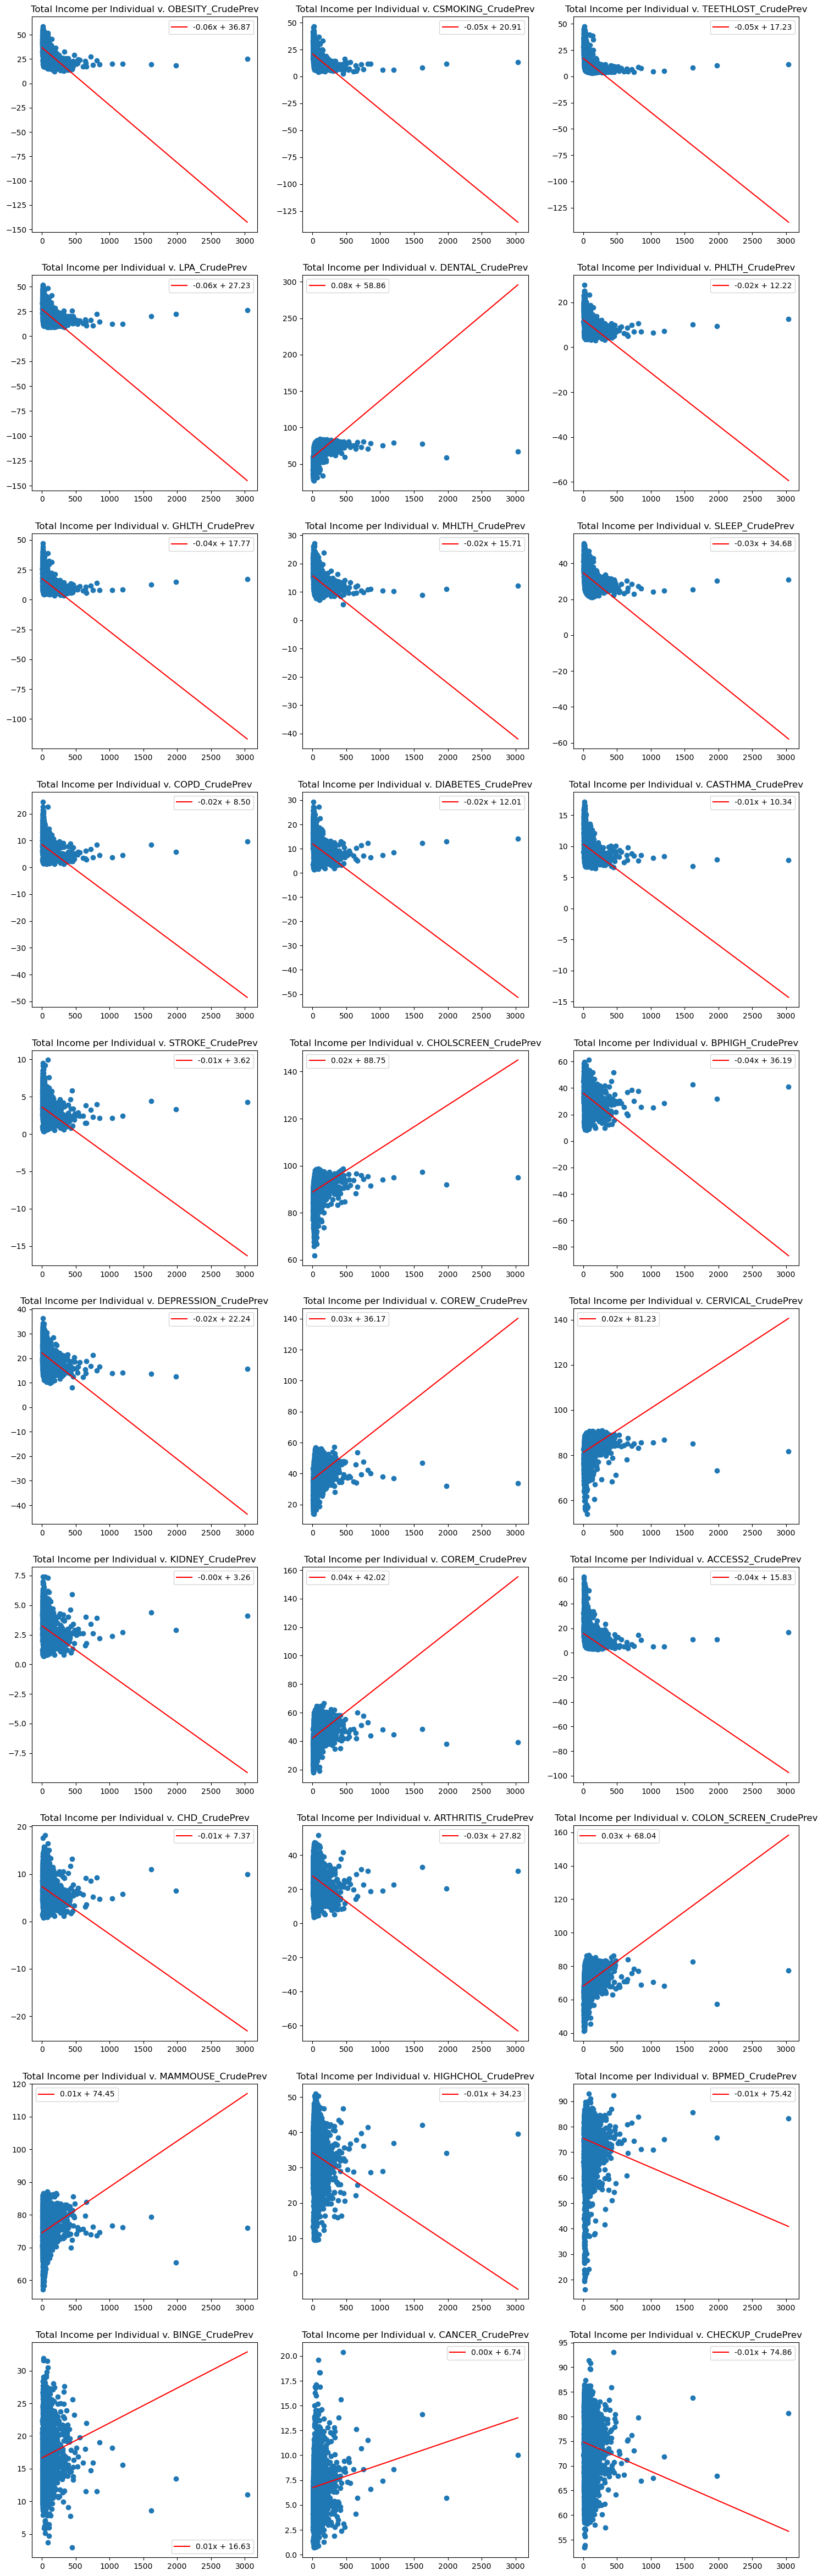

In [77]:
# Results indicate that we have to remove outliers for the charts to make sense, probably

rows = 10
cols = 3
fig, axs = plt.subplots(rows, cols)
fig.set_figheight(6*rows)
fig.set_figwidth(6*cols)
for i in range(rows):
    for j in range(cols):
        X = strength.index[0]
        Y = strength.index[i*cols+j+1]
        result = reg_this(medical_df[X], medical_df[Y])
        axs[i, j].scatter(medical_df[X], medical_df[Y])
        axs[i, j].plot(medical_df[X], (result.slope*medical_df[X]+result.intercept), label = f"{result.slope:.2f}x + {result.intercept:.2f}", color = "red")
        axs[i, j].set_title(f"{X} v. {Y}")
        axs[i, j].legend(loc="best")
plt.show()